In this notebook we project the simulation data onto the dunbrack states / noise and build MSM based on this state assignment.

In [1]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
from pathlib import Path
from natsort import natsorted

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')

from MSMAnalysis import *
import mdtraj as md
from funcs_abl_featurise import *
from funcs_db_assign import *
from funcs_plotting import *
from funcs_sample import *

In [2]:
protein = 'abl'
base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')
# Load the ftrajs to assign dunbrack states
features = ['dbdist', 'dbdihed']
MA = MSMAnalysis(protein, trajlen_cutoff=0)
MA.load_ftrajs(features=features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')
dbdist, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdist']), stride=1, len_cutoff=0)
dbdihed, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdihed']), stride=1, len_cutoff=0, convert_dihed=False)

Loading feature:  dbdist


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:00<00:00, 8301.10it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:00<00:00, 3025.36it/s]


Features loaded: {'dbdihed', 'dbdist'}
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 17856.22it/s]


Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 4070.51it/s]


In [3]:
distance_centroids = np.load('/home/rzhu/Desktop/projects/kinase_analysis/data/abl/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True)
dihedral_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item()

Assign trajectories to distance and dihedral groups. Save to disk. 

In [4]:
wk_dir = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data/abl/ftrajs')
dist_ftrajs = natsorted([f for f in wk_dir.glob('run*-clone?_dbdist.npy')])
dihed_ftrajs = natsorted([f for f in wk_dir.glob('run*-clone?_dbdihed.npy')])

In [11]:
for dist_f, dihed_f in zip(dist_ftrajs, dihed_ftrajs):
    dist = np.load(dist_f)
    dihed = np.load(dihed_f)
    stem = dist_f.stem.split('_')[0]
    dfg_featuriser(dists=dist, diheds=dihed[:,[0,1,2,3,4,5,8]], 
                   dist_centroids=distance_centroids, dihed_centroids=dihedral_centroids, 
                   save_to_disk=[wk_dir/stem + '_distgroup.npy',
                                 wk_dir/stem + '_dihedgroup.npy'])

Use dihedral group labels as Markov states

In [21]:
dihed_group_files = natsorted([f for f in wk_dir.glob('run*-clone?_dihedgroup.npy')])
dihed_group_dtrajs = [np.load(f) for f in dihed_group_files]

In [39]:
dtrajs, mapping = prepare_ftrajs({'dtraj':dihed_group_dtrajs}, stride=1, len_cutoff=1000, convert_dihed=False)

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 12521.46it/s]


In [41]:
from deeptime.markov import *
from pyemma.msm import *

In [51]:
msm = estimate_markov_model(dtrajs, lag=1, core_set=list(range(0,8)))

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 2 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 3 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/pyemma/util/discrete_trajectories.py:302: UserWarning: The trajectory with index 7 had to be truncated for not starting in a core.
  warnings.warn('The trajectory with index {i} had to be truncated for not starting in a core.'.format(i=i))
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/pyemma/util/

In [54]:
protein = 'abl'
base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')
hp_dict = Adict({'hp_id': 2,
                'trajlen__cutoff': 1000,
                'n__boot': 20,
                'seed': 49587,
                'tica__lag': 10,
                'tica__stride': 1000,
                'tica__dim': 20,
                'cluster__k': 1000,
                'cluster__stride': 100,
                'cluster__maxiter': 1000,
                'markov__lag': 100})
all_features = ['dbdist', 'dbdihed']
MA = MSMAnalysis(protein, trajlen_cutoff=1000)
MA.load_ftrajs(features=all_features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')

Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 11881.88it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:00<00:00, 5743.09it/s]

Features loaded: {'dbdihed', 'dbdist'}


In [55]:
study = MA.create_study(study_name=f'dunbrack_coarse_grain', 
                        hp_dict=hp_dict, 
                        features=all_features,
                        stride=1,
                        create_new=True,
                        wk_dir=base_path/f'data/{protein}/msm/validation/dunbrack_coarse_grain')
study.set_pcca(6)
study.estimate_MSM()
study.save_models()

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 1040.88it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Parameter hp_id not allowed, ignore. Check the allowed parameters
Parameter trajlen__cutoff not allowed, ignore. Check the allowed parameters
Parameter n__boot not allowed, ignore. Check the allowed parameters
Parameter seed not allowed, ignore. Check the allowed parameters
Number of metastable states not specified. Defaulting to 5. Run set_pcca() to set the number of metastable states
Set number of metastable states to  6


100%|██████████| 426/426 [00:01<00:00, 352.29it/s]                        
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:16<00:00, 59.99it/s]  
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 4/4 [00:07<00:00,  1.79s/it]                                    


MSM estimation complete


FileNotFoundError: [Errno 2] No such file or directory: '/home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/validation/dunbrack_coarse_grain/plots/timescales.png'

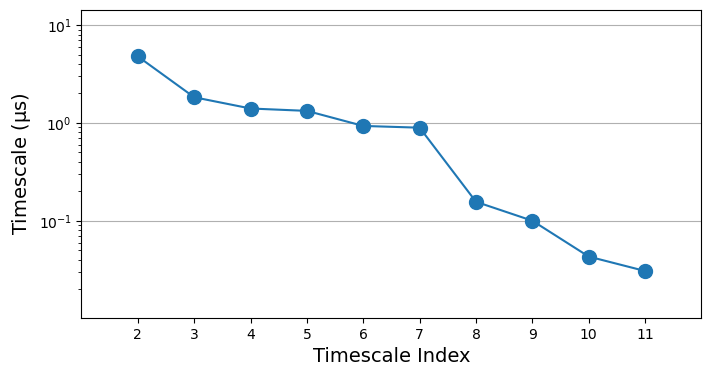

In [61]:
plot_ts(study.msm_mod.timescales(), 10, hp_dict.markov__lag, scaling=0.00005, unit="$\mathrm{\mu s}$", 
        savedir= study.fig_dir/'timescales.png')

/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu

FileNotFoundError: [Errno 2] No such file or directory: '/home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/validation/dunbrack_coarse_grain/plots/fes_pcca.png'

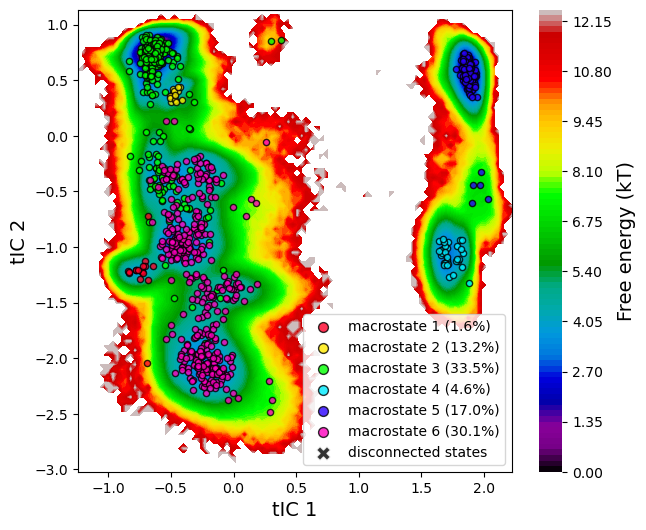

In [56]:
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=80,
        state_assignment=study.pcca_mod.assignments,
        state_population=study.pcca_mod.coarse_grained_stationary_probability,
        linewidth=1,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        d_centers_marker='X',
        legend_marker_sizes=[200, 200, 200, 200, 200, 200, 100],
        savedir = study.fig_dir/'fes_pcca.png')